In [1]:
import gymnasium as gym
import ale_py

gym.register_envs(ale_py)

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from gym.wrappers import StepAPICompatibility
from collections import deque
import random
import pickle
import tqdm

## Environment Setup

In [2]:
acrobot_env_name = 'Acrobot-v1'
acrobot_env = gym.make(acrobot_env_name)
# acrobot_env = StepAPICompatibility(acrobot_env)
print("Action space:", acrobot_env.action_space)
print("State space:", acrobot_env.observation_space)
print(acrobot_env.env.spec.id)

Action space: Discrete(3)
State space: Box([ -1.        -1.        -1.        -1.       -12.566371 -28.274334], [ 1.        1.        1.        1.       12.566371 28.274334], (6,), float32)
Acrobot-v1


In [3]:
assault_env_name = "ALE/Assault-ram-v5"
assault_env = gym.make(assault_env_name)
# assault_env = StepAPICompatibility(assault_env)
print("Action space:", assault_env.action_space)
print("State space:", assault_env.observation_space)
print(assault_env.env.spec.id)

Action space: Discrete(7)
State space: Box(0, 255, (128,), uint8)
ALE/Assault-ram-v5


## Implementation

In [4]:
class ZNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128, device="cpu"):
        super(ZNetwork, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
        )
        self.mlp.apply(init_weights)
        self.device = device
        self.to(self.device)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x)
            x = x.to(self.device)
        return self.mlp(x)


# approximates the state-value function using NN
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim=128, device="cpu"):
        super(ValueNetwork, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
        )
        self.mlp.apply(init_weights)
        self.device = device
        self.to(self.device)

    def forward(self, x):
        if not isinstance(x, torch.Tensor):
            x = torch.FloatTensor(x)
            x = x.to(self.device)
        return self.mlp(x)


class BoltzmannPolicy:
    def __init__(self, z_network, temperature=1.0, device="cpu"):
        self.z_network = z_network
        self.temperature = temperature
        self.device = device

    # Boltzmann distribution
    def select_action(self, state):
        # forward ZNetwork
        state_input = torch.as_tensor(state).float().unsqueeze(0).to(self.device)
        z_s = self.z_network(state_input)
        logits = z_s / self.temperature
        probs = torch.nn.functional.softmax(logits, dim=-1)

        # categorical distribution and sample action, exmaple Categorical(probs: tensor([0.1, 0.2, 0.7]))
        m = torch.distributions.Categorical(probs)
        action = m.sample()

        # return action.item(), m.log_prob(action), probs.detach().numpy()
        return action.item(), m.log_prob(action), probs.cpu().detach().numpy()


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.uniform_(m.weight, -0.001, 0.001)
        nn.init.uniform_(m.bias, -0.001, 0.001)


# REINFORCE is the agent that will train the NN
class REINFORCE:
    def __init__(
        self,
        env,
        lr=0.001,
        gamma=0.99,
        temperature=1.0,
        temp_decay=0.9999,
        decreasing_temp=False,
        max_steps_per_episode=500,
        device="cpu",
    ):
        self.device = device
        if not torch.cuda.is_available():
            self.device = "cpu"
        print(f"Using device: {self.device}")

        self.env = env

        self.state_dim = self.env.observation_space.shape[0]
        self.action_dim = self.env.action_space.n
        self.z_network = ZNetwork(self.state_dim, self.action_dim, device=self.device)
        # Use Adam instead of SGD
        self.optimizer = optim.Adam(self.z_network.parameters(), lr=lr)
        self.gamma = gamma

        self.max_steps_per_episode = max_steps_per_episode
        self.env_name = self.env.env.spec.id

        if temperature == "decreasing":
            self.initial_temp = 1
            self.decreasing_temp = True
            self.temp_decay = temp_decay
        else:
            self.initial_temp = temperature
            self.decreasing_temp = decreasing_temp
            self.temp_decay = temp_decay

        self.policy = BoltzmannPolicy(
            self.z_network, self.initial_temp, device=self.device
        )

    def train_episode(self):
        state, _ = self.env.reset()
        if self.env_name == "ALE/Assault-ram-v5":
            state = (state / 255) - 0.5
        log_probs = []
        rewards = []
        done = False
        n_steps = 0

        # generate trajectory
        while not done:
            action, log_prob, _ = self.policy.select_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
            n_steps += 1
            if n_steps >= self.max_steps_per_episode:
                done = True
        returns = self._compute_returns(rewards)
        if returns.std() > 0:
            returns = (returns - returns.mean()) / (returns.std() + 1e-8)

        # add negative sign because Torch minimizes
        log_probs_tensor = torch.cat(log_probs)
        log_probs_tensor = log_probs_tensor.to(self.device)
        policy_loss = -torch.sum(log_probs_tensor * returns)

        # backprop
        self.optimizer.zero_grad()
        policy_loss.backward()
        self.optimizer.step()

        if self.decreasing_temp:
            self.policy.temperature *= self.temp_decay

        return sum(rewards)

    def _compute_returns(self, rewards):
        returns = []
        Gt = 0
        for Rt in reversed(rewards):
            Gt = Rt + self.gamma * Gt
            returns.insert(0, Gt)
        returns = torch.tensor(returns, device=self.device)
        return returns

    def reset_temperature(self):
        self.policy.temperature = self.initial_temp


class ActorCritic:
    def __init__(
        self,
        env,
        lr_policy=1e-3,
        lr_value=1e-3,
        gamma=0.99,
        temperature=1.0,
        temp_decay=0.9999,
        decreasing_temp=False,
        max_steps_per_episode=500,
        device="cpu",
    ):
        self.device = device
        if not torch.cuda.is_available():
            self.device = "cpu"
        print(f"Using device: {self.device}")

        self.env = env
        self.env_name = env.env.spec.id if env.env and env.env.spec else ""
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n

        # actor is ZNetwork
        self.z_network = ZNetwork(self.state_dim, self.action_dim, device=self.device)
        self.policy = BoltzmannPolicy(
            self.z_network, temperature=temperature, device=self.device
        )
        self.optimizer_policy = optim.Adam(self.z_network.parameters(), lr=lr_policy)

        # critic is ValueNetwork
        self.value_network = ValueNetwork(self.state_dim, device=self.device)
        self.optimizer_value = optim.Adam(self.value_network.parameters(), lr=lr_value)

        self.gamma = gamma
        self.max_steps_per_episode = max_steps_per_episode

        if temperature == "decreasing":
            self.initial_temp = 1
            self.decreasing_temp = True
            self.temp_decay = temp_decay
        else:
            self.initial_temp = temperature
            self.decreasing_temp = decreasing_temp
            self.temp_decay = temp_decay

    def train_episode(self):
        state, _ = self.env.reset()
        if self.env_name == "ALE/Assault-ram-v5":
            state = (state / 255.0) - 0.5
        done = False
        total_reward = 0.0
        steps = 0

        while not done:
            action, log_prob, _ = self.policy.select_action(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated

            # A = R + gamma * V(next_state) − V(state)
            state_tensor = torch.tensor(
                state, dtype=torch.float32, device=self.z_network.device
            )
            # value_s = self.value_network(torch.FloatTensor(state_tensor))
            value_s = self.value_network((state_tensor))
            if done:
                value_s_prime = 0.0  # No future reward if episode is done
            else:
                next_state_tensor = torch.tensor(
                    next_state, dtype=torch.float32, device=self.z_network.device
                )
                value_s_prime = self.value_network(next_state_tensor)

            # one‐step TD error
            # update critic to reduce TD error to minimize (advantage)^2, no minus sign
            td_target = reward + self.gamma * value_s_prime
            advantage = td_target - value_s
            value_loss = advantage.pow(2).mean()
            self.optimizer_value.zero_grad()
            value_loss.backward()
            self.optimizer_value.step()

            # update actor with advantage
            policy_loss = -log_prob * advantage.detach()
            self.optimizer_policy.zero_grad()
            policy_loss.backward()
            self.optimizer_policy.step()

            state = next_state
            total_reward += reward
            steps += 1

            if self.decreasing_temp:
                self.policy.temperature *= self.temp_decay

            if steps >= self.max_steps_per_episode:
                break

        return total_reward

    def reset_temperature(self):
        self.policy.temperature = self.initial_temp


def run_trial(env, seed, lr, temperature, algorithm, device="cpu"):
    torch.manual_seed(seed)
    np.random.seed(seed)

    num_episodes = 1000

    agent = None
    if algorithm == "REINFORCE":
        agent = REINFORCE(env, lr=lr, temperature=temperature, device=device)
    elif algorithm == "Actor-Critic":
        agent = ActorCritic(
            env,
            lr_policy=lr,
            lr_value=lr,
            gamma=0.99,
            temperature=temperature,
            device=device,
        )

    torch.set_grad_enabled(True)

    episode_rewards = []
    for _ in tqdm.tqdm(range(num_episodes)):
        agent.reset_temperature()
        total_reward = agent.train_episode()
        episode_rewards.append(total_reward)
    return episode_rewards

## Experiment


In [6]:
step_sizes = [0.01]
temperatures = [1, "decreasing"]
seeds = range(10)
env_names = ["Acrobot-v1", "ALE/Assault-ram-v5"]
algorithms = ["REINFORCE", "Actor-Critic"]

total_trials = (
    len(env_names) * len(seeds) * len(step_sizes) * len(temperatures) * len(algorithms)
)

# load pickle file for results, check if file exists
try:
    with open("results_q3.pkl", "rb") as f:
        results = pickle.load(f)
except:
    results = {}

trials_completed = 0
for env_name in env_names:
    env = gym.make(env_name)
    for lr in step_sizes:
        for temperature in temperatures:
            for algorithm in algorithms:
                for seed in seeds:
                    if not (
                        (
                            env_name,
                            seed,
                            lr,
                            temperature,
                            algorithm,
                        )
                        in results.keys()
                    ):
                        episode_rewards = run_trial(
                            env, seed, lr, temperature, algorithm, device="cuda"
                        )
                        results[
                            (
                                env_name,
                                seed,
                                lr,
                                temperature,
                                algorithm,
                            )
                        ] = episode_rewards
                        with open("results_q3.pkl", "wb") as f:
                            pickle.dump(results, f)
                    trials_completed += 1
                    print(f"Completed {trials_completed}/{total_trials} trials")

Completed 1/80 trials
Completed 2/80 trials
Completed 3/80 trials
Completed 4/80 trials
Completed 5/80 trials
Completed 6/80 trials
Completed 7/80 trials
Completed 8/80 trials
Completed 9/80 trials
Completed 10/80 trials
Completed 11/80 trials
Completed 12/80 trials
Completed 13/80 trials
Completed 14/80 trials
Completed 15/80 trials
Completed 16/80 trials
Completed 17/80 trials
Completed 18/80 trials
Completed 19/80 trials
Completed 20/80 trials
Completed 21/80 trials
Completed 22/80 trials
Completed 23/80 trials
Completed 24/80 trials
Completed 25/80 trials
Completed 26/80 trials
Completed 27/80 trials
Completed 28/80 trials
Completed 29/80 trials
Completed 30/80 trials
Completed 31/80 trials
Completed 32/80 trials
Completed 33/80 trials
Completed 34/80 trials
Completed 35/80 trials
Completed 36/80 trials
Completed 37/80 trials
Completed 38/80 trials
Completed 39/80 trials
Completed 40/80 trials
Completed 41/80 trials
Completed 42/80 trials
Completed 43/80 trials
Completed 44/80 tria

100%|██████████| 1000/1000 [21:46<00:00,  1.31s/it]


Completed 77/80 trials
Using device: cuda


100%|██████████| 1000/1000 [19:33<00:00,  1.17s/it]


Completed 78/80 trials
Using device: cuda


100%|██████████| 1000/1000 [20:24<00:00,  1.22s/it]


Completed 79/80 trials
Using device: cuda


100%|██████████| 1000/1000 [17:52<00:00,  1.07s/it]

Completed 80/80 trials


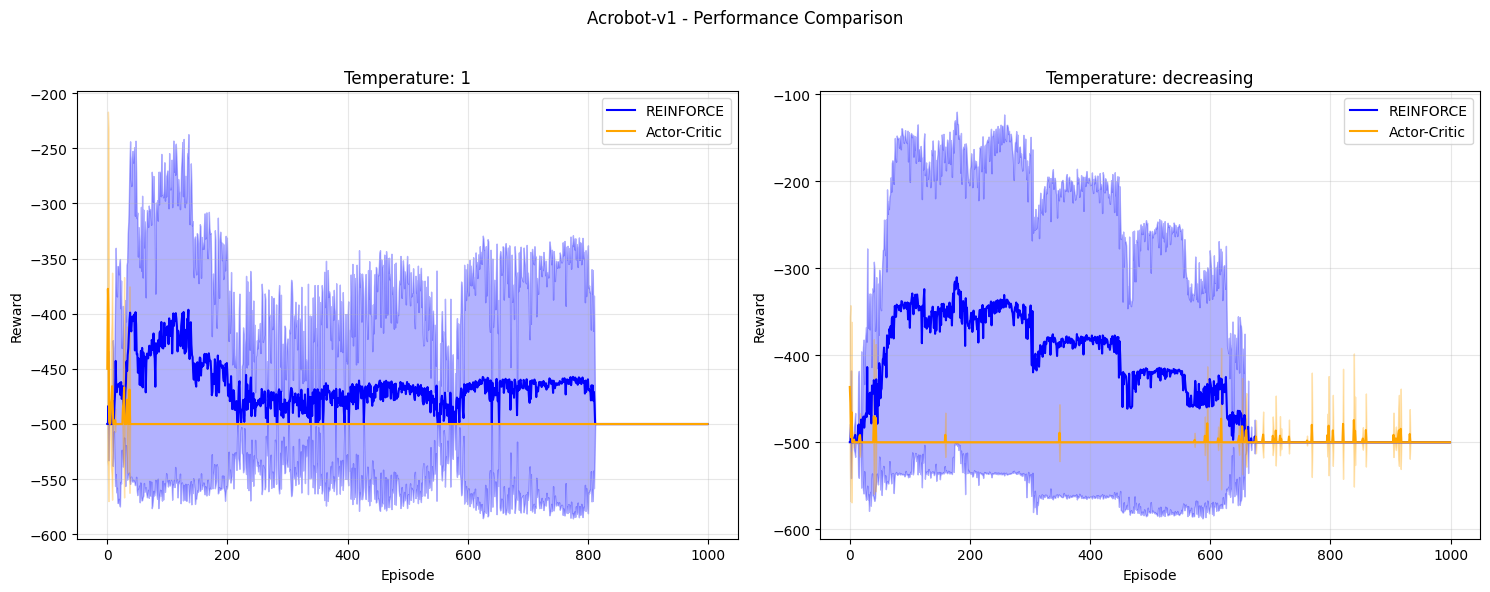

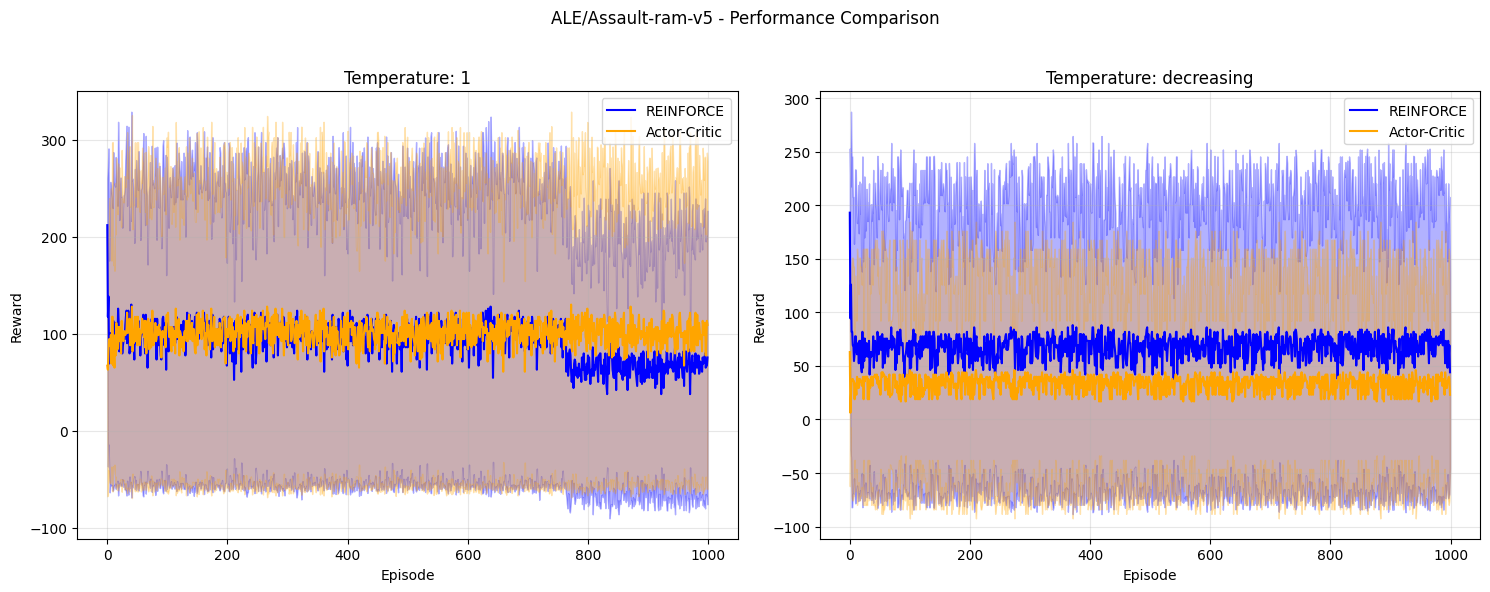

In [7]:
with open("results_q3.pkl", "rb") as f:
    results = pickle.load(f)

step_sizes = [0.01]
temperatures = [1, "decreasing"]
algorithms = ["REINFORCE", "Actor-Critic"]
env_names = ["Acrobot-v1", "ALE/Assault-ram-v5"]

algorithm_colors = {"REINFORCE": "blue", "Actor-Critic": "orange"}

for env_name in env_names:
    fig, axes = plt.subplots(1, len(temperatures), figsize=(15, 6))
    fig.suptitle(f"{env_name} - Performance Comparison")

    if len(temperatures) == 1:
        axes = [axes]

    for i, temperature in enumerate(temperatures):
        ax = axes[i]
        ax.set_title(f"Temperature: {temperature}")
        ax.set_xlabel("Episode")
        ax.set_ylabel("Reward")

        for algorithm, color in algorithm_colors.items():
            all_rewards = []

            for seed in range(10):
                key = (env_name, seed, step_sizes[0], temperature, algorithm)
                if key in results:
                    all_rewards.append(results[key])

            if all_rewards:
                all_rewards = np.array(all_rewards)
                mean_rewards = np.mean(all_rewards, axis=0)
                std_rewards = np.std(all_rewards, axis=0)

                episodes = range(len(mean_rewards))
                ax.plot(episodes, mean_rewards, label=algorithm, color=color)

                ax.fill_between(
                    episodes,
                    mean_rewards - std_rewards,
                    mean_rewards + std_rewards,
                    color=color,
                    alpha=0.3,
                )

        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(f"{env_name.replace('/', '_')}_performance.png")
    plt.show()
    plt.close()